In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .appName('Pyspark_MLlib').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/28 11:59:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.ml.clustering import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the files here

In [191]:
path='kafka_csv_data/*.csv'
data =spark.read.csv(path, header = True, inferSchema= True)

In [4]:
# # Converting the string type to timestamp
# #to_timestamp()
# df2.select(col("input"), 
#     to_timestamp(col("input"), "MM-dd-yyyy HH mm ss SSS").alias("to_timestamp") 
#   ).show(truncate=False)

In [5]:
data.show(5)

+--------------+--------+------------------+----------+-------------------+--------------+-----------------+------------+------------+------------+------------+------------------+---------------+--------------+----------------+------------------+------------+
|Summons_Number|Plate_ID|Registration_State|Plate_Type|         Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Street_Code1|Street_Code2|Street_Code3|Violation_Precinct|Issuer_Precinct|Violation_Time|Violation_County|       Street_Name|Vehicle_Year|
+--------------+--------+------------------+----------+-------------------+--------------+-----------------+------------+------------+------------+------------+------------------+---------------+--------------+----------------+------------------+------------+
|    1447152396| JET2661|                NY|       PAS|2019-06-28 00:00:00|            21|              SDN|         BMW|       27390|       36290|       36350|                26|             26|         1000A|          

In [111]:
# data.select('Registration_State').distinct().count()

65

In [6]:
data.printSchema()

root
 |-- Summons_Number: long (nullable = true)
 |-- Plate_ID: string (nullable = true)
 |-- Registration_State: string (nullable = true)
 |-- Plate_Type: string (nullable = true)
 |-- Issue_Date: timestamp (nullable = true)
 |-- Violation_Code: integer (nullable = true)
 |-- Vehicle_Body_Type: string (nullable = true)
 |-- Vehicle_Make: string (nullable = true)
 |-- Street_Code1: integer (nullable = true)
 |-- Street_Code2: integer (nullable = true)
 |-- Street_Code3: integer (nullable = true)
 |-- Violation_Precinct: integer (nullable = true)
 |-- Issuer_Precinct: integer (nullable = true)
 |-- Violation_Time: string (nullable = true)
 |-- Violation_County: string (nullable = true)
 |-- Street_Name: string (nullable = true)
 |-- Vehicle_Year: integer (nullable = true)



In [7]:
#  Getting the dimensions of the data at hand

(data.count() ,len(data.columns))

(806489, 17)

In [8]:
# data.describe()

## Adding new columns:
### 'Day_of_Week' and 'Day_of_Month' to the data frame


In [9]:
newdf = data

In [10]:
from pyspark.sql.functions import date_format
from pyspark.sql.functions import dayofmonth,dayofweek

newdf = newdf.withColumn('Day_of_Week', dayofweek(newdf.Issue_Date))\
.withColumn('Day_of_Month',dayofmonth(newdf.Issue_Date))

In [11]:
newdf.select('Summons_Number','Issue_Date','Day_of_Month','Day_of_Week').show(5)

+--------------+-------------------+------------+-----------+
|Summons_Number|         Issue_Date|Day_of_Month|Day_of_Week|
+--------------+-------------------+------------+-----------+
|    1447152396|2019-06-28 00:00:00|          28|          6|
|    1447152402|2019-06-28 00:00:00|          28|          6|
|    1447152554|2019-06-16 00:00:00|          16|          1|
|    1447152580|2019-06-24 00:00:00|          24|          2|
|    1447152724|2019-07-06 00:00:00|           6|          7|
+--------------+-------------------+------------+-----------+
only showing top 5 rows



In [12]:
newdf.printSchema()

root
 |-- Summons_Number: long (nullable = true)
 |-- Plate_ID: string (nullable = true)
 |-- Registration_State: string (nullable = true)
 |-- Plate_Type: string (nullable = true)
 |-- Issue_Date: timestamp (nullable = true)
 |-- Violation_Code: integer (nullable = true)
 |-- Vehicle_Body_Type: string (nullable = true)
 |-- Vehicle_Make: string (nullable = true)
 |-- Street_Code1: integer (nullable = true)
 |-- Street_Code2: integer (nullable = true)
 |-- Street_Code3: integer (nullable = true)
 |-- Violation_Precinct: integer (nullable = true)
 |-- Issuer_Precinct: integer (nullable = true)
 |-- Violation_Time: string (nullable = true)
 |-- Violation_County: string (nullable = true)
 |-- Street_Name: string (nullable = true)
 |-- Vehicle_Year: integer (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Day_of_Month: integer (nullable = true)



# Trying to combine the latitude and longitude for each registration state using two dataframes

In [192]:
path='state_data/*.csv'
mapdata =spark.read.csv(path, header = True, inferSchema= True)

In [193]:
mapdata.columns

['State', 'Latitude', 'Longitude', 'City']

In [105]:
mapdata.select('City').distinct().count()

51

In [15]:
# Combining two dataframes for Latitude and Longitude values.

newdf = newdf.join(mapdata , newdf.Registration_State == mapdata.State)


In [16]:
newdf = newdf.drop('State')

In [17]:
newdf.select('Summons_Number','Registration_State','Latitude','Longitude','City').show(20)

+--------------+------------------+----------+-----------+------------+
|Summons_Number|Registration_State|  Latitude|  Longitude|        City|
+--------------+------------------+----------+-----------+------------+
|    1447152396|                NY|40.7056258|  -73.97968|    New York|
|    1447152402|                NY|40.7056258|  -73.97968|    New York|
|    1447152554|                NY|40.7056258|  -73.97968|    New York|
|    1447152580|                NY|40.7056258|  -73.97968|    New York|
|    1447152724|                NY|40.7056258|  -73.97968|    New York|
|    1447152992|                NY|40.7056258|  -73.97968|    New York|
|    1447153315|                NY|40.7056258|  -73.97968|    New York|
|    1447153327|                NY|40.7056258|  -73.97968|    New York|
|    1447153340|                NY|40.7056258|  -73.97968|    New York|
|    1447153352|                ME|45.2185133|-69.0148656|       Maine|
|    1447153649|                NY|40.7056258|  -73.97968|    Ne

# Trying to create clusters using Kmeans Algorithm and get results

In [18]:
newdf.printSchema()

root
 |-- Summons_Number: long (nullable = true)
 |-- Plate_ID: string (nullable = true)
 |-- Registration_State: string (nullable = true)
 |-- Plate_Type: string (nullable = true)
 |-- Issue_Date: timestamp (nullable = true)
 |-- Violation_Code: integer (nullable = true)
 |-- Vehicle_Body_Type: string (nullable = true)
 |-- Vehicle_Make: string (nullable = true)
 |-- Street_Code1: integer (nullable = true)
 |-- Street_Code2: integer (nullable = true)
 |-- Street_Code3: integer (nullable = true)
 |-- Violation_Precinct: integer (nullable = true)
 |-- Issuer_Precinct: integer (nullable = true)
 |-- Violation_Time: string (nullable = true)
 |-- Violation_County: string (nullable = true)
 |-- Street_Name: string (nullable = true)
 |-- Vehicle_Year: integer (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Day_of_Month: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- City: string (nullable = true)



## Selecting the features column. 

In [19]:
cat_col = ['Registration_State', 'Plate_Type', 'Vehicle_Body_Type']      #string categorical columns

In [20]:
num_col = ['Summons_Number','Violation_Code','Day_of_Month','Day_of_Week']       #numerical columns

In [21]:
print(cat_col)
print(num_col)

['Registration_State', 'Plate_Type', 'Vehicle_Body_Type']
['Summons_Number', 'Violation_Code', 'Day_of_Month', 'Day_of_Week']


### Importing the OneHotEncoder and StringIndexer for processing categorical striong values for features column

In [22]:
from pyspark.ml.feature import (OneHotEncoder,StringIndexer,VectorAssembler)

In [23]:
string_indexer = [StringIndexer(inputCol=x, outputCol= x + "_StringIndexer", handleInvalid="skip")
                 for x in cat_col]

In [24]:
one_hot_encoder = [
    OneHotEncoder(
    inputCols=[f"{x}_StringIndexer" for x in cat_col],
        outputCols=[f"{x}_OneHotEncoder" for x in cat_col],
    )
]

In [25]:
one_hot_encoder

[OneHotEncoder_60538f8d055f]

In [26]:
trydf = newdf

## Vector Assembler to convert all the columns into vectors for the ML Algorithm

In [27]:
from pyspark.ml.feature import VectorAssembler

In [28]:
assemblerInput = [x  for x in num_col]
assemblerInput += [f"{x}_OneHotEncoder" for x in cat_col]

In [29]:
assemblerInput

['Summons_Number',
 'Violation_Code',
 'Day_of_Month',
 'Day_of_Week',
 'Registration_State_OneHotEncoder',
 'Plate_Type_OneHotEncoder',
 'Vehicle_Body_Type_OneHotEncoder']

In [30]:
assembler = VectorAssembler(inputCols=[x for x in assemblerInput],outputCol="features")

## Creating a Pipeline for data processing

In [31]:
#Creating stages of processing
stages =[]
stages += string_indexer
stages += one_hot_encoder
stages += [assembler]

In [32]:
stages

[StringIndexer_5f44122c8eed,
 StringIndexer_c23b71704299,
 StringIndexer_d5ee2717c44a,
 OneHotEncoder_60538f8d055f,
 VectorAssembler_8bf2d1e3f5a3]

In [33]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(stages)
model = pipeline.fit(trydf)
transformed_df = model.transform(trydf)

In [83]:
transformed_df.select('Summons_Number','Registration_State','Vehicle_Body_Type','Violation_Code','Violation_Precinct','Latitude', 'Longitude','City','Day_of_Week','Day_of_Month','features').show(20)

+--------------+------------------+-----------------+--------------+------------------+----------+-----------+------------+-----------+------------+--------------------+
|Summons_Number|Registration_State|Vehicle_Body_Type|Violation_Code|Violation_Precinct|  Latitude|  Longitude|        City|Day_of_Week|Day_of_Month|            features|
+--------------+------------------+-----------------+--------------+------------------+----------+-----------+------------+-----------+------------+--------------------+
|    1447152396|                NY|              SDN|            21|                26|40.7056258|  -73.97968|    New York|          6|          28|(590,[0,1,2,3,4,5...|
|    1447152402|                NY|              SDN|            20|                26|40.7056258|  -73.97968|    New York|          6|          28|(590,[0,1,2,3,4,5...|
|    1447152554|                NY|             SUBN|            19|                26|40.7056258|  -73.97968|    New York|          1|          16|(5

In [84]:
final_df = transformed_df.select('Summons_Number','Registration_State','Vehicle_Body_Type','Violation_Code','Violation_Precinct','Latitude', 'Longitude','City','Day_of_Week','Day_of_Month','features')

In [86]:
final_df.show(10)

+--------------+------------------+-----------------+--------------+------------------+----------+-----------+--------+-----------+------------+--------------------+
|Summons_Number|Registration_State|Vehicle_Body_Type|Violation_Code|Violation_Precinct|  Latitude|  Longitude|    City|Day_of_Week|Day_of_Month|            features|
+--------------+------------------+-----------------+--------------+------------------+----------+-----------+--------+-----------+------------+--------------------+
|    1447152396|                NY|              SDN|            21|                26|40.7056258|  -73.97968|New York|          6|          28|(590,[0,1,2,3,4,5...|
|    1447152402|                NY|              SDN|            20|                26|40.7056258|  -73.97968|New York|          6|          28|(590,[0,1,2,3,4,5...|
|    1447152554|                NY|             SUBN|            19|                26|40.7056258|  -73.97968|New York|          1|          16|(590,[0,1,2,3,4,5...|
|   

## Standardize the values in the dataframe using StandardScaler

In [87]:
from pyspark.ml.feature import StandardScaler

In [88]:
# Creating scaler from the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="zfeatures", withStd=True, withMean=False)

In [89]:
# Applying the scaler to the dataframe and transforming it
scalerModel = scaler.fit(final_df)
cluster_df = scalerModel.transform(final_df)

## Selecting K using Elbow Curve Method for WSSE value (Within sum squared errors) (The value of WSS should be less)

In [90]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [91]:
eval  = ClusteringEvaluator(predictionCol="prediction",
                           featuresCol="zfeatures",
                           metricName="silhouette",
                           distanceMeasure="squaredEuclidean")

In [92]:
silouette_score = []
print("""
Silouette Score for Kmeans Clustering 
=====================================
Model\tScore\t
=====\t=====\t
""")
for k in range(2,13):
    kmeans_algo = KMeans(featuresCol="zfeatures",k=k)
    kmeans_fit = kmeans_algo.fit(cluster_df)
    output = kmeans_fit.transform(cluster_df)
    score = eval.evaluate(output)
    silouette_score.append(score)
    print(f"K{k}\t{round(score,3)}\t")


Silouette Score for Kmeans Clustering 
Model	Score	
=====	=====	



K2	0.999	


K3	0.989	


K4	0.634	


K5	0.635	


K6	0.989	


K7	-0.466	


K8	-0.374	


K9	-0.296	


K10	-0.278	


K11	-0.277	


K12	-0.277	


In [93]:
silouette_score

[0.9987210305485128,
 0.9886942590741173,
 0.634057511535049,
 0.6345926172695406,
 0.9887405418803805,
 -0.46555613971057463,
 -0.37390987944505216,
 -0.295670433063589,
 -0.2780988647110348,
 -0.277052731404616,
 -0.2769410765996404]

TypeError: object of type 'int' has no len()

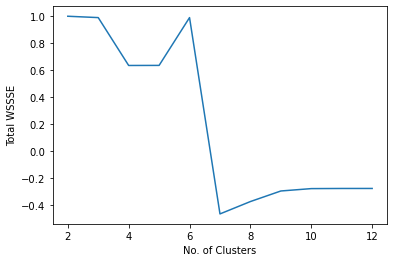

In [94]:
plt.plot(range(2,13),silouette_score);
plt.xlabel("No. of Clusters");
plt.ylabel("Total WSSSE");
plt.xticks(k)

## Taking K=4 becasue from the graph, after k=4 the data is not spliting much, So we will take k=4 as the number of clusters

In [95]:
k=4
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('zfeatures')
model = kmeans.fit(cluster_df)
centers = model.clusterCenters()

In [96]:
print("CLuster Centers: ")
for c in centers:
    print(c)

CLuster Centers: 
[2.62632546e+00 1.76236247e+00 2.08771259e+00 2.50700380e+00
 2.30483246e+00 1.16779745e-01 1.70854032e-01 6.58497434e-02
 5.47968336e-02 2.26367219e-03 3.87249112e-02 3.51680502e-02
 3.87595451e-02 3.22713303e-02 3.49212319e-02 2.12624882e-02
 1.51711397e-02 4.64405558e-02 2.89351936e-02 1.94138901e-02
 6.58268671e-03 5.46264942e-03 1.93694068e-02 1.43026538e-02
 2.88177980e-02 1.73908252e-02 3.58677152e-03 6.21871231e-03
 1.73702776e-02 4.41408791e-03 1.28916434e-02 1.91391457e-02
 1.41116003e-02 1.61728808e-02 8.92433639e-03 1.15613204e-02
 1.34901265e-02 1.02202855e-02 8.66709494e-03 7.44949166e-03
 6.91066231e-03 7.49510115e-03 5.90950969e-03 5.92535691e-03
 4.86607338e-03 5.03293950e-03 4.43587628e-03 2.13281401e-03
 8.42210154e-03 3.37142825e-03 3.98485462e-03 4.91285257e-03
 2.50706074e-03 3.17119099e-03 2.33713179e+00 0.00000000e+00
 1.56843396e-01 1.55902838e-01 1.39436269e-01 0.00000000e+00
 5.26861033e-02 0.00000000e+00 6.43058666e-02 2.07998811e-03
 7.644

# We will apply the prediction on the data now

In [97]:
cluster_df.show(5)

+--------------+------------------+-----------------+--------------+------------------+----------+---------+--------+-----------+------------+--------------------+--------------------+
|Summons_Number|Registration_State|Vehicle_Body_Type|Violation_Code|Violation_Precinct|  Latitude|Longitude|    City|Day_of_Week|Day_of_Month|            features|           zfeatures|
+--------------+------------------+-----------------+--------------+------------------+----------+---------+--------+-----------+------------+--------------------+--------------------+
|    1447152396|                NY|              SDN|            21|                26|40.7056258|-73.97968|New York|          6|          28|(590,[0,1,2,3,4,5...|(590,[0,1,2,3,4,5...|
|    1447152402|                NY|              SDN|            20|                26|40.7056258|-73.97968|New York|          6|          28|(590,[0,1,2,3,4,5...|(590,[0,1,2,3,4,5...|
|    1447152554|                NY|             SUBN|            19|       

In [130]:
print(cluster_df.columns)

['Summons_Number', 'Registration_State', 'Vehicle_Body_Type', 'Violation_Code', 'Violation_Precinct', 'Latitude', 'Longitude', 'City', 'Day_of_Week', 'Day_of_Month', 'features', 'zfeatures']


## Prediction for Violation Precinct

In [ ]:
vip_output = model.transform(cluster_df).select('Violation_Precinct','prediction')
vip_rows = vip_output.collect()

In [ ]:
vip_rows[:3]

In [ ]:
df_vip = spark.createDataFrame(vip_rows)

In [ ]:
df_vip.groupBy('Violation_Precinct').count().show()

### First Answer = Judging by the count , The Violation Precinct "19" has the maximum number of Violations in the area "

# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------


## Prediction for Registration_State

In [121]:
city_output = model.transform(cluster_df).select('Registration_State','prediction')
city_rows = city_output.collect()
city_sum = spark.createDataFrame(city_rows)

In [122]:
city_sum.groupBy('prediction').count().show()

21/11/28 13:55:58 WARN TaskSetManager: Stage 954 contains a task of very large size (1764 KiB). The maximum recommended task size is 1000 KiB.


+----------+------+
|prediction| count|
+----------+------+
|         0|363773|
|         1|345696|
|         2| 88978|
|         3|     6|
+----------+------+



In [123]:
city_sum.groupBy('Registration_State').count().show(65)                                #bcz there are 51 cities

21/11/28 13:55:59 WARN TaskSetManager: Stage 957 contains a task of very large size (1764 KiB). The maximum recommended task size is 1000 KiB.


+------------------+------+
|Registration_State| count|
+------------------+------+
|                SC|  1653|
|                AZ|  1480|
|                LA|   254|
|                MN|  1139|
|                NJ| 55569|
|                DC|   170|
|                OR|   714|
|                VA|  4242|
|                RI|   685|
|                NH|   489|
|                MI|   792|
|                NV|   108|
|                WI|   573|
|                ID|    36|
|                CA|  1131|
|                CT|  8595|
|                NE|    65|
|                NC|  3688|
|                VT|   540|
|                MD|  2853|
|                DE|   775|
|                MO|   282|
|                IL|  1813|
|                ME|  1973|
|                WA|   472|
|                ND|    15|
|                MS|   174|
|                AL|   586|
|                IN|  6325|
|                OH|  1946|
|                TN|  1055|
|                IA|   110|
|                NM|

###  Second Answer ---> Judging by the output, from the 51 Cities......
+ "New York" has maximum number of violations ,i.e. 648461
+ "New Jersey" has the second most number of violations, i.e. 55569

# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------


# Prediction on Day_of_week
#### Day_of_Week
+ 1-Sunday
+ 2-Monday
+ 3-Tuesday
+ 4-Wednesday
+ 5-Thursday
+ 6-Friday
+ 7-Saturday

In [131]:
week_output = model.transform(cluster_df).select('Day_of_Week','prediction')
week_rows = week_output.collect()
week_sum = spark.createDataFrame(week_rows)

In [132]:
week_sum.groupBy('Day_of_Week').count().show()

21/11/28 14:14:20 WARN TaskSetManager: Stage 962 contains a task of very large size (1179 KiB). The maximum recommended task size is 1000 KiB.


+-----------+------+
|Day_of_Week| count|
+-----------+------+
|          7| 66684|
|          6|163542|
|          5|132400|
|          1| 27365|
|          3|143881|
|          2|129964|
|          4|134617|
+-----------+------+



### Third Answer ---> Maximum Number of Violations occured on "Friday" i.e the weekend

# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------


## Prediction on Day_of_Month

In [133]:
mon_output = model.transform(cluster_df).select('Day_of_Month','prediction')
mon_rows = mon_output.collect()
mon_sum = spark.createDataFrame(mon_rows)

In [135]:
mon_sum.groupBy('Day_of_Month').count().show(31)

21/11/28 14:23:11 WARN TaskSetManager: Stage 970 contains a task of very large size (1179 KiB). The maximum recommended task size is 1000 KiB.


+------------+-----+
|Day_of_Month|count|
+------------+-----+
|          26|37082|
|          29|14236|
|          19|45651|
|          22|34363|
|           7| 6265|
|          31| 1020|
|          25|28122|
|           6|10591|
|           9|27690|
|          27|29788|
|          17|42435|
|          28|28671|
|           5|19181|
|           1|24879|
|          10|23007|
|           3|20100|
|          12|51435|
|           8|21764|
|          11|41840|
|           2|28733|
|           4| 4755|
|          13|17554|
|          18|43355|
|          14| 9696|
|          21| 9401|
|          15|44823|
|          30| 5186|
|          23|33187|
|          20|16051|
|          16|44355|
|          24|33237|
+------------+-----+



### Fourth Answer ---> Maximum Number of Violations occured on the 12th day of the month.

# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------

## Mapping the clusters on geomap using latitude and longitude data

In [136]:
print(cluster_df.columns)

['Summons_Number', 'Registration_State', 'Vehicle_Body_Type', 'Violation_Code', 'Violation_Precinct', 'Latitude', 'Longitude', 'City', 'Day_of_Week', 'Day_of_Month', 'features', 'zfeatures']


In [137]:
map_output = model.transform(cluster_df).select('Summons_Number', 'Registration_State', 'Vehicle_Body_Type', 'Violation_Code', 'Violation_Precinct', 'Latitude', 'Longitude','prediction')
map_rows = map_output.collect()
map_df = spark.createDataFrame(map_rows)

In [138]:
map_df.show(3)

+--------------+------------------+-----------------+--------------+------------------+----------+---------+----------+
|Summons_Number|Registration_State|Vehicle_Body_Type|Violation_Code|Violation_Precinct|  Latitude|Longitude|prediction|
+--------------+------------------+-----------------+--------------+------------------+----------+---------+----------+
|    1447152396|                NY|              SDN|            21|                26|40.7056258|-73.97968|         1|
|    1447152402|                NY|              SDN|            20|                26|40.7056258|-73.97968|         1|
|    1447152554|                NY|             SUBN|            19|                26|40.7056258|-73.97968|         0|
+--------------+------------------+-----------------+--------------+------------------+----------+---------+----------+
only showing top 3 rows



21/11/28 14:40:38 WARN TaskSetManager: Stage 975 contains a task of very large size (8901 KiB). The maximum recommended task size is 1000 KiB.


In [180]:
## Install these if you don't have them installed
# !pip install geopandas
# !pip install plotly
# !pip install contextily
# !pip install plotly-geo

In [141]:
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

In [167]:
import contextily as cx

In [183]:
import plotly.figure_factory as  ff

In [139]:
geo_data = map_df.toPandas()

21/11/28 14:54:48 WARN TaskSetManager: Stage 976 contains a task of very large size (8901 KiB). The maximum recommended task size is 1000 KiB.


In [140]:
geo_data.head(5)

,Summons_Number,Registration_State,Vehicle_Body_Type,Violation_Code,Violation_Precinct,Latitude,Longitude,prediction
0,1447152396,NY,SDN,21,26,40.705626,-73.97968,1
1,1447152402,NY,SDN,20,26,40.705626,-73.97968,1
2,1447152554,NY,SUBN,19,26,40.705626,-73.97968,0
3,1447152580,NY,SDN,19,26,40.705626,-73.97968,1
4,1447152992,NY,SUBN,46,26,40.705626,-73.97968,0


In [142]:
#  creating the geo-points to plot for the data
geo_points_df = gpd.GeoDataFrame(geo_data, geometry= gpd.points_from_xy(
geo_data.Longitude, geo_data.Latitude))

In [144]:
geo_points_df.head()

,Summons_Number,Registration_State,Vehicle_Body_Type,Violation_Code,Violation_Precinct,Latitude,Longitude,prediction,geometry
0,1447152396,NY,SDN,21,26,40.705626,-73.97968,1,POINT (-73.97968 40.70563)
1,1447152402,NY,SDN,20,26,40.705626,-73.97968,1,POINT (-73.97968 40.70563)
2,1447152554,NY,SUBN,19,26,40.705626,-73.97968,0,POINT (-73.97968 40.70563)
3,1447152580,NY,SDN,19,26,40.705626,-73.97968,1,POINT (-73.97968 40.70563)
4,1447152992,NY,SUBN,46,26,40.705626,-73.97968,0,POINT (-73.97968 40.70563)


In [145]:
# Get the built in world map from the geopandas library
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

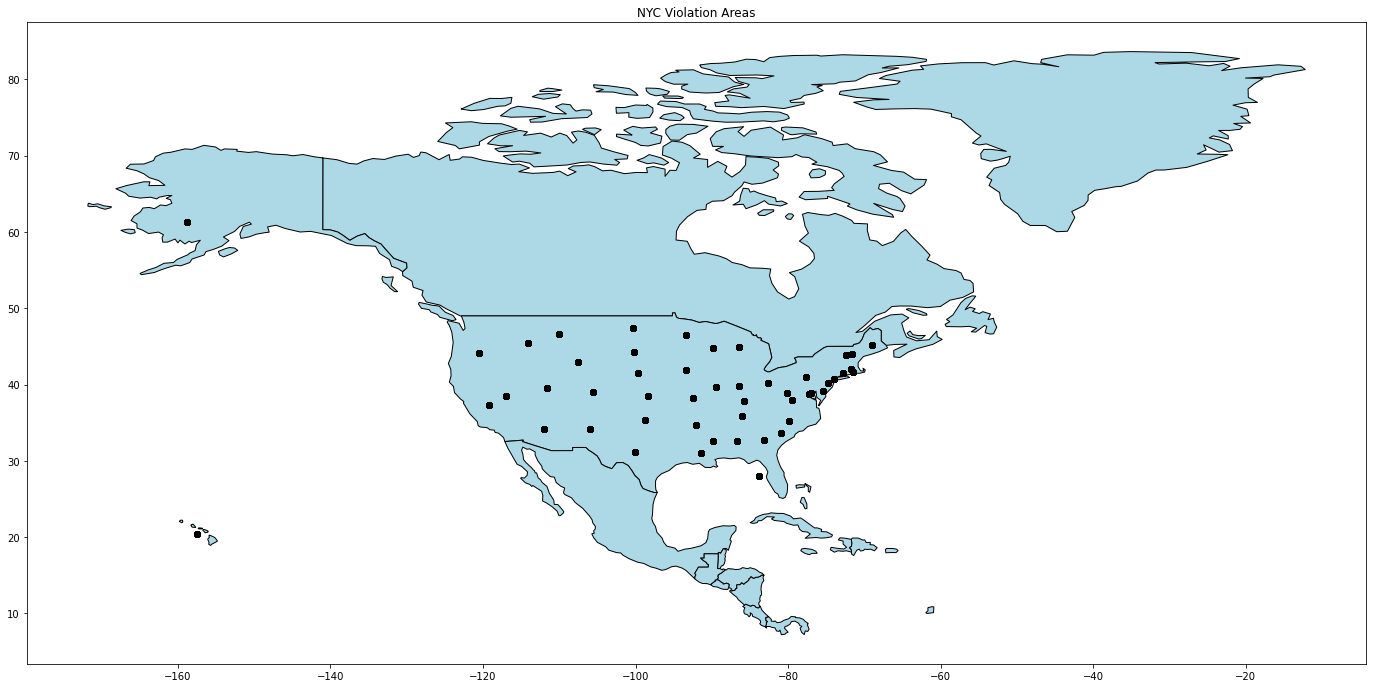

In [190]:
# Plot the data on the map
axis = world_data[world_data.continent == 'North America'].plot(
color = 'lightblue', edgecolor = 'black')

geo_points_df.plot(ax = axis, color = 'black')
plt.title('NYC Violation Areas')

fig = plt.gcf()
fig.set_size_inches(24,24)
fig.savefig('matplot.png',dpi = 200)
plt.show()